In [190]:
import math, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [2]:
def prepare_data (location: str) -> pd.DataFrame:
    """Return pandas dataframe with proper labeled columns and adjusted
    values.

    Args:
        location (str): The location directory in string form.

    Returns:
        pd.DataFrame: data file -> pandas dataframe
    """
    cols = ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']
    df = pd.read_csv(location, names=cols, sep=r'\s+')
    df['pos_i'] = df['pos_i'] // 1000000
    df['pos_j'] = df['pos_j'] // 1000000
    return df

In [80]:
def find_chr_length (data: pd.DataFrame) -> dict[str: tuple]:
    """Return a dictionary containing each unique chromosome mapped to their lengths
    as a tuple (min_length, max_length).
    
    Args:
        data (pd.DataFrame): DataFrame with ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']

    Returns:
        dict: chromosome -> length (min, max)
    """
    chr_bounds = {}
    chromosomes = sorted(set(df['chr_i']).union(df['chr_j']), key=lambda x: int(x[3:]) if x[3:].isdigit() else 100)
    for chr_ in chromosomes:
            max_i = data.loc[data['chr_i'] == chr_, 'pos_i'].max()
            max_j = data.loc[data['chr_j'] == chr_, 'pos_j'].max()
            min_i = data.loc[data['chr_i'] == chr_, 'pos_i'].min()
            min_j = data.loc[data['chr_j'] == chr_, 'pos_j'].min()
            chr_bounds[chr_] = (min(min_i, min_j), max(max_i, max_j))
    return chr_bounds

In [79]:
def build_chr_block_matrix(data: pd.DataFrame) -> pd.DataFrame:
    """Return a DataFrame where rows and columns are chromosomes and
    each cell contains a symmetric contact matrix (DataFrame) between those chromosomes.

    Args:
        data (pd.DataFrame): DataFrame with ['chr_i', 'pos_i', 'chr_j', 'pos_j', 'contacts']

    Returns:
        pd.DataFrame: block DataFrame of contact matrices
    """
    # compute length of chromosome
    chr_bounds = find_chr_length(data)
    chromosomes = sorted(set(data['chr_i']).union(data['chr_j']), key=lambda x: int(x[3:]) if x[3:].isdigit() else 100)

    # initialize zero block matrix as pandas dataframe
    chr_block_df = pd.DataFrame(0, index=chromosomes, columns=chromosomes, dtype=object)

    # fill diagonal with contact matrices between chromosomes
    for chr_i in chromosomes:
        for chr_j in chromosomes:
            # set lengths for chromosome contact matrix
            min_i, max_i = chr_bounds[chr_i]
            min_j, max_j = chr_bounds[chr_j]
            row_bins = list(range(min_i, max_i + 1))
            col_bins = list(range(min_j, max_j + 1))

            # find the diagonal point
            if chr_i == chr_j:
                # initialize zero matrix of size chromosome
                mat = pd.DataFrame(0, index=row_bins, columns=col_bins)
                # find subset of actual contact data for this chr pair
                subdf = data[(data['chr_i'] == chr_i) & (data['chr_j'] == chr_j)]
                for _, row in subdf.iterrows():
                    i, j, c = row['pos_i'], row['pos_j'], row['contacts']
                    mat.iat[i - min_i, j - min_j] = c
                # set diagonal block as that contact matrix
                chr_block_df.at[chr_i, chr_j] = mat
    return chr_block_df

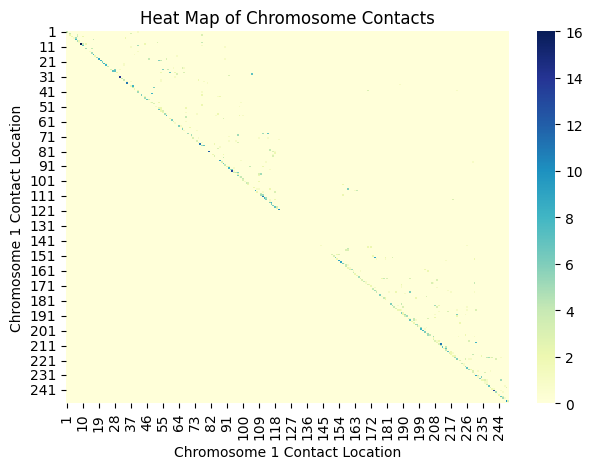

In [69]:
df = prepare_data('/Users/salah/Documents/hic-cell-classification/data/HAP1/ml1_AAGCCGGT-ATACATGT.txt')
matrix = build_chr_block_matrix(df)

sns.heatmap(matrix.at['chr1', 'chr1'], cmap='YlGnBu')
plt.title("Heat Map of Chromosome Contacts")
plt.xlabel("Chromosome 1 Contact Location")
plt.ylabel("Chromosome 1 Contact Location")
plt.tight_layout()
plt.show()

In [ ]:
def cell_summary_stats(matrix: pd.DataFrame) -> dict:
    """
    Return summary statistics of the cell based on intra-chromosomal contact matrices
    (i.e., the diagonal blocks only).

    Args:
        matrix (pd.DataFrame): block matrix where only diagonal cells contain data

    Returns:
        dict: {
            'total_contacts': float,
            'mean_contact': float,
            'var_contact': float
        }
    """
    all_contacts = []

    for chr in matrix.index:
        block = matrix.at[chr, chr]
        # convert block as numpy array and then flaten into 1D array and append
        all_contacts.append(block.values.ravel())

    # transform all 1D arrays into one 1D array
    flat_contacts = np.concatenate(all_contacts)

    num_zero = np.sum(flat_contacts == 0)
    num_nonzero = np.sum(flat_contacts > 0)

    return {
        'total_contacts': float(np.sum(flat_contacts)),
        'mean_contact': float(np.mean(flat_contacts)),
        'var_contact': float(np.var(flat_contacts)),
        'num_zero_contacts': int(num_zero),
        'num_nonzero_contacts': int(num_nonzero)
    }

In [ ]:
def per_chr_summary_stats(df: pd.DataFrame, matrix: pd.DataFrame) -> dict:
    """
    For each chromosome's intra-chromosomal contact matrix (on the diagonal),
    return summary stats including:
      - Total, mean, variance of contact intensity
      - Total, mean, variance of diagonal-only entries
      - Mean and variance of distance-from-diagonal (|i - j|) for non-zero contacts

    Args:
        df (pd.DataFrame): not used
        matrix (pd.DataFrame): 23x23 block matrix with only diagonal blocks populated

    Returns:
        dict: {
            'chrX': {
                'total': float,
                'mean': float,
                'var': float,
                'diag_total': float,
                'diag_mean': float,
                'diag_var': float,
                'contact_dist_mean': float,
                'contact_dist_var': float
            },
            ...
        }
    """
    stats = {}

    for chr in matrix.index:
        block = matrix.at[chr, chr]

        # convert blocks and giagonal into numpy arrays
        values = block.values
        diag_values = np.diag(values)

        # Get distance-from-diagonal (abs(i - j)) for non-zero contacts
        contact_dists = []
        # get the row dimension of array
        n = values.shape[0]

        # iterate through numpy array
        for i in range(n):
            for j in range(n):
                contact = values[i, j]
                if contact > 0:
                    dist = abs(i - j)
                    contact_dists.append(dist)

        # convert list into numpy array
        contact_dists = np.array(contact_dists)

        stats[chr] = {
            'total': float(np.sum(values)),
            'mean': float(np.mean(values)),
            'var': float(np.var(values)),

            'diag_total': float(np.sum(diag_values)),
            'diag_mean': float(np.mean(diag_values)),
            'diag_var': float(np.var(diag_values)),

            'contact_dist_mean': float(np.mean(contact_dists)) if len(contact_dists) > 0 else 0.0,
            'contact_dist_var': float(np.var(contact_dists)) if len(contact_dists) > 0 else 0.0
        }

    return stats

In [109]:
def read_all_in_cell_type(folder_path: str, file_suffix: str = ".txt") -> pd.DataFrame:
    """
    Loop through all cell files in a folder and extract cell-level and
    per-chromosome contact statistics.

    Args:
        folder_path (str): Path to directory with cell contact files.
        file_suffix (str): File extension to filter on (default = ".txt").

    Returns:
        pd.DataFrame: One row per cell, with summary statistics as columns.
    """
    cells = []

    for fname in os.listdir(folder_path):
        cell_id = os.path.splitext(fname)[0]
        cell_path = os.path.join(folder_path, fname)

        try:
            # Load and process each cell data
            df = prepare_data(location=cell_path)
            matrix = build_chr_block_matrix(df)

            features = {'cell_id': cell_id}

            # add summary stats for whole cell as features
            features.update(cell_summary_stats(matrix))

            # add summary stats by chromosome for each cell
            per_chr_stats = per_chr_summary_stats(df, matrix)
            for chr_name, chr_stat_dict in per_chr_stats.items():
                for stat_name, value in chr_stat_dict.items():
                    features[f"{chr_name}_{stat_name}"] = value

            # add features for this cells as a dictionary
            cells.append(features)

        except Exception as error:
            print(f"Error processing {fname}: {error}")

    return pd.DataFrame(cells).set_index('cell_id')

gm_12878 = read_all_in_cell_type(folder_path='/Users/salah/Documents/hic-cell-classification/data/GM12878')
hap_1 = read_all_in_cell_type(folder_path='/Users/salah/Documents/hic-cell-classification/data/HAP1')
hela = read_all_in_cell_type(folder_path='/Users/salah/Documents/hic-cell-classification/data/Hela')
k_562 = read_all_in_cell_type(folder_path='/Users/salah/Documents/hic-cell-classification/data/K562')

In [240]:
def keep_top_75_percent(group):
    threshold = group["num_zero_contacts"].quantile(0.75)
    return group[group["num_zero_contacts"] <= threshold]

In [241]:
gm_12878['cell_type'] = 'GM12878'
hap_1['cell_type'] = 'HAP1'
hela['cell_type'] = 'HELA'
k_562['cell_type'] = 'K562'
master_df = pd.concat([gm_12878, hap_1, hela, k_562], ignore_index=True)
master_df = master_df.groupby("cell_type", group_keys=False).apply(keep_top_75_percent).copy()

/var/folders/zz/fn6m71xn7kx55y0nwsb0gxsh0000gn/T/ipykernel_30750/3352756738.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  master_df = master_df.groupby("cell_type", group_keys=False).apply(keep_top_75_percent).copy()


In [242]:
# drop non-numerical columns
features_df = master_df.drop(columns=["cell_type", "cell_id"], errors="ignore")

# standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

# find PC1 & PC2 of scaled data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# find UMAP1 & UMAP2
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


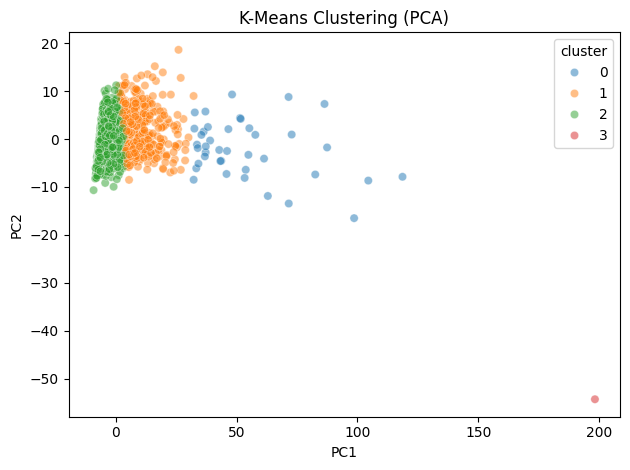

In [243]:
# fit KMean to PCA
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

cluster_df = pd.DataFrame(X_pca[:, :2], columns=["PC1", "PC2"])
cluster_df["cluster"] = cluster_labels
cluster_df["cell_type"] = master_df["cell_type"].values

sns.scatterplot(data=cluster_df, x="PC1", y="PC2", hue="cluster", palette="tab10", alpha=0.5)
plt.title("K-Means Clustering (PCA)")
plt.tight_layout()
plt.show()

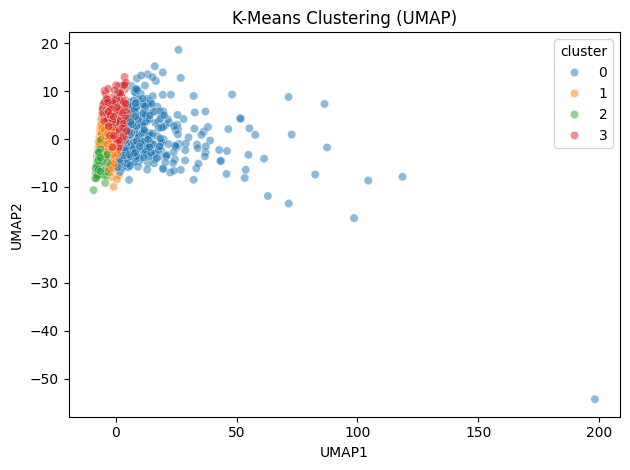

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_umap)

cluster_df = pd.DataFrame(X_pca[:, :2], columns=["UMAP1", "UMAP2"])
cluster_df["cluster"] = cluster_labels
cluster_df["cell_type"] = master_df["cell_type"].values

sns.scatterplot(data=cluster_df, x="UMAP1", y="UMAP2", hue="cluster", palette="tab10", alpha=0.5)
plt.title("K-Means Clustering (UMAP)")
plt.tight_layout()
plt.show()

In [245]:
ks = range(2, 10)  # Try cluster counts from 2 to 9
ari_scores_pca = []
ari_scores_umap = []

true_labels = master_df['cell_type'].values

# PCA-based ARI
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    pred_labels = kmeans.fit_predict(X_pca)
    ari = adjusted_rand_score(true_labels, pred_labels)
    ari_scores_pca.append(ari)

# UMAP-based ARI
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    pred_labels = kmeans.fit_predict(X_umap)
    ari = adjusted_rand_score(true_labels, pred_labels)
    ari_scores_umap.append(ari)

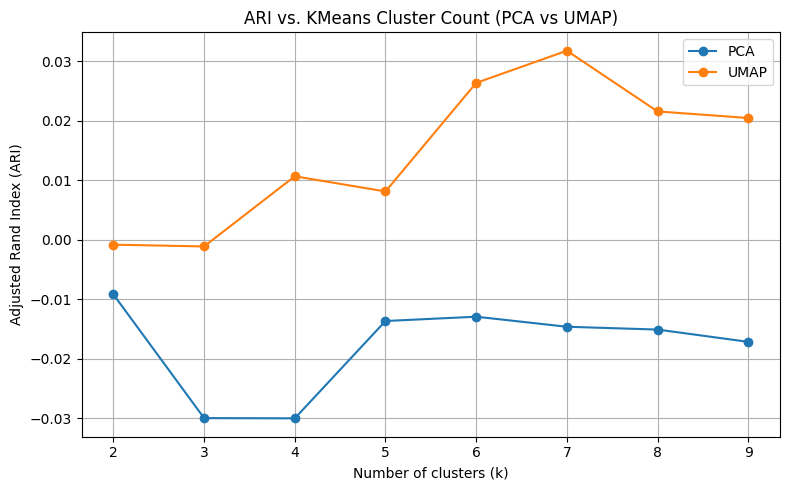

In [246]:
plt.figure(figsize=(8, 5))
plt.plot(ks, ari_scores_pca, marker='o', label="PCA")
plt.plot(ks, ari_scores_umap, marker='o', label="UMAP")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Adjusted Rand Index (ARI)")
plt.title("ARI vs. KMeans Cluster Count (PCA vs UMAP)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

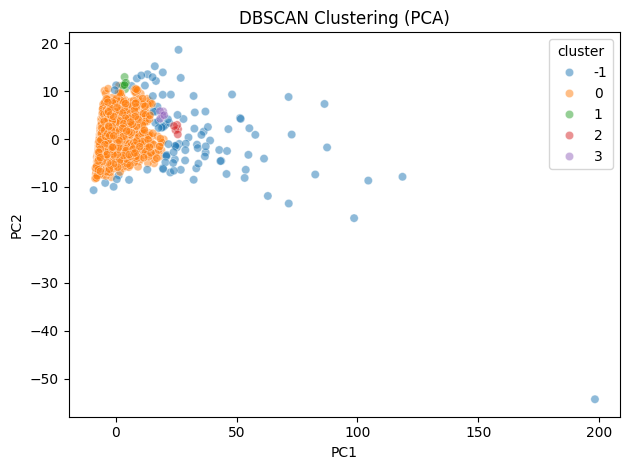

In [248]:
db = DBSCAN(eps=1.5, min_samples=5)
cluster_labels = db.fit_predict(X_pca)

cluster_df = pd.DataFrame(X_pca[:, :2], columns=["PC1", "PC2"])
cluster_df["cluster"] = cluster_labels
cluster_df["cell_type"] = master_df["cell_type"].values

sns.scatterplot(data=cluster_df, x="PC1", y="PC2", hue="cluster", palette="tab10", alpha=0.5)
plt.title("DBSCAN Clustering (PCA)")
plt.tight_layout()
plt.show()


In [113]:
def extract_upper_triangle_features(matrix: pd.DataFrame) -> np.ndarray:
    """
    Extracts and concatenates the upper triangle (excluding diagonal)
    from all diagonal contact matrices in a block matrix.
    
    Returns a 1D feature vector.
    """
    features = []
    for chr in matrix.index:
        block = matrix.at[chr, chr]
        if isinstance(block, pd.DataFrame):
            values = block.values
            triu_indices = np.triu_indices_from(values, k=1)  # exclude diagonal
            upper_triangle = values[triu_indices]
            features.append(upper_triangle)
    return np.concatenate(features)